# Using Bedrock ModelAnalyzer

In [1]:
import pickle

import numpy as np
import pandas as pd
import lightgbm as lgb
from bedrock_client.bedrock.analyzer.model_analyzer import ModelAnalyzer
from bedrock_client.bedrock.analyzer import ModelTypes

from preprocess.constants import FEATURES, TARGET, CONFIG_FAI

##  Load model and test dataset

Here we use our model artefact trained elsewhere.

In [2]:
model = pickle.load(open("output/lgb_model.pkl", "rb"))

In [3]:
test_df = pd.read_parquet("output/test.gz.parquet")
x_test = test_df[FEATURES]
y_test = test_df[TARGET].values

In [5]:
# Predict
y_pred = model.predict(x_test)

## Explainability and Fairness using ModelAnalyzer

We shall use `bedrock_client.bedrock.analyzer.model_analyzer.ModelAnalyzer` to generate model explainability analysis and fairness metrics locally. You can use it to generate and log them in Bedrock.

Refer to [documentation](https://docs.basis-ai.com/guides/explainability-and-fairness) and [API references](https://docs.basis-ai.com/guides/explainability-and-fairness/api-references) for more details.

In [6]:
analyzer = ModelAnalyzer(model, "credit_risk", model_type=ModelTypes.TREE)

# To set test data used for calculating explainability
analyzer.test_features(x_test)
analyzer.stored_sample_limit(sample_limit=None)  # To output all SHAP values for the test data

# To set fairness configuration, groundtruth labels and model inference results for generating fairness metrics
analyzer.fairness_config(CONFIG_FAI).test_labels(y_test).test_inference(y_pred)

(shap_values, base_values, global_xai_data, fairness_metrics) = analyzer.analyze()

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


## Analyzer outputs

### SHAP values
Array of SHAP values calculated on provided `test_features`

In [7]:
shap_values

[array([[-9.65729617e-03, -7.35284364e-04,  0.00000000e+00, ...,
         -4.37946776e-05, -3.83989573e-04, -3.65481713e-03],
        [-8.82619117e-03, -9.62625079e-04,  0.00000000e+00, ...,
         -1.01399103e-04, -4.37147971e-04,  8.28396387e-05],
        [ 2.01185989e-01,  1.30885374e-02,  0.00000000e+00, ...,
         -3.13169637e-05, -1.51110698e-03,  8.36172922e-05],
        ...,
        [-7.63092206e-03, -8.76610071e-04,  0.00000000e+00, ...,
         -3.13169637e-05, -1.35225969e-03,  5.54862176e-05],
        [-6.58468913e-03, -4.35749662e-04,  0.00000000e+00, ...,
         -1.01399103e-04, -1.53696174e-03,  8.43588105e-05],
        [-7.31749830e-03, -6.84699247e-04,  0.00000000e+00, ...,
         -4.44219492e-05, -3.29267709e-04,  2.48305015e-05]]),
 array([[ 9.65729617e-03,  7.35284364e-04,  0.00000000e+00, ...,
          4.37946776e-05,  3.83989573e-04,  3.65481713e-03],
        [ 8.82619117e-03,  9.62625079e-04,  0.00000000e+00, ...,
          1.01399103e-04,  4.37147971e-04, -8.28396387e-05],
        [-2.01185989e-01, -1.30885374e-02,  0.00000000e+00, ...,
          3.13169637e-05,  1.51110698e-03, -8.36172922e-05],
        ...,
        [ 7.63092206e-03,  8.76610071e-04,  0.00000000e+00, ...,
          3.13169637e-05,  1.35225969e-03, -5.54862176e-05],
        [ 6.58468913e-03,  4.35749662e-04,  0.00000000e+00, ...,
          1.01399103e-04,  1.53696174e-03, -8.43588105e-05],
        [ 7.31749830e-03,  6.84699247e-04,  0.00000000e+00, ...,
          4.44219492e-05,  3.29267709e-04, -2.48305015e-05]])]

### Base value
Base value is the average model output calculated on background data

In [9]:
base_values

array([ 2.9689217, -2.9689217])

### Global XAI data
Global XAI returns the mean absolute shap values of each feature, together with its correlation with said feature

In [12]:
global_xai_data.keys()

dict_keys(['class 0', 'class 1'])

In [16]:
global_xai_data["class 1"]["EXT_SOURCE_1"]

{'mean_abs_shap': 0.1250874817302989, 'corrcoeff': -0.9179096128397835}

### Fairness metrics

Since fairness config is passed, the model analyzer also returns the fairness metrics.

In [17]:
fairness_metrics.keys()

dict_keys(['CODE_GENDER', 'NAME_EDUCATION_TYPE_Higher_education'])


In [20]:
fairness_df, confusion_matrices = fairness_metrics["CODE_GENDER"]["class 1"]

In [21]:
fairness_df

,metric,criterion,all,unprivileged,privileged,ratio,fair?
0,Equal opportunity,Separation,0.949934,0.937799,0.964809,0.972004,Yes
1,Predictive parity,Sufficiency,0.520548,0.530612,0.500000,1.061224,Yes
2,Statistical parity,Independence,0.007300,0.007468,0.006979,1.070156,Yes
3,Predictive equality,Separation,0.003787,0.003744,0.003873,0.966602,Yes
4,Equalized odd,Separation,0.026927,0.032973,0.019532,1.688125,No
5,Conditional use accuracy equality,Sufficiency,0.735208,0.735208,0.701830,1.047558,Yes


In [22]:
confusion_matrices

{'all': {'TP': 38.0, 'FP': 35.0, 'TN': 9206.0, 'FN': 721.0},
 'privileged': {'TP': 12.0, 'FP': 12.0, 'TN': 3086.0, 'FN': 329.0},
 'unprivileged': {'TP': 26.0, 'FP': 23.0, 'TN': 6120.0, 'FN': 392.0}}

## Optional: Plotting explainability

Using the compute SHAP values and `shap.summary_plot`, we can obtain a preliminary view of the effects of the top features.

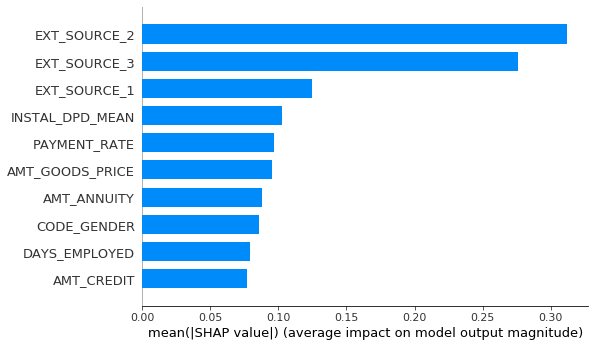

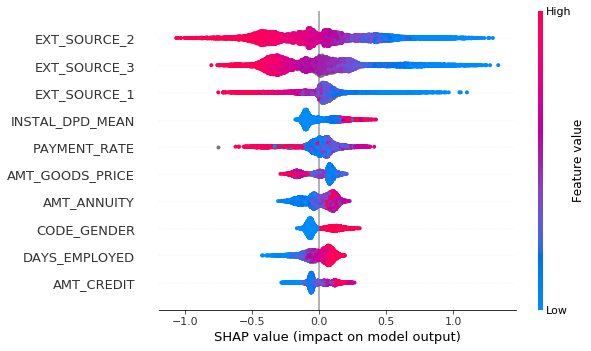

In [19]:
import shap

# We use the SHAP values that correspond to `TARGET=1`, ie shap_values[1]
shap.summary_plot(shap_values[1], x_test, plot_type="bar", max_display=10)
shap.summary_plot(shap_values[1], x_test, max_display=10)